In [1]:
import sys
import time
import numpy as np
import pylab as pl
import random

sys.path.append('../') # get out of the sandbox

from vent.controller.control_module import get_control_module
from vent.common.message import SensorValues, ControlSetting, Alarm, AlarmSeverity, ControlSettingName

In [ ]:
from vent.common.message import Val

In [2]:
Controller = get_control_module(sim_mode=True)

Controller.start()
time.sleep(1)  # Try this
ls = []
tt = []
t0 = time.time()
for t in np.arange(0, 30,0.05):
    
    if t%5==0:  # ask for a heartbeat from thread every 5 seconds
        print(Controller.heartbeat())
        print(t)    
    ## Do things
    
       ### Make a cascade of changes that will not trigger alarms
    if t == 0:
        command = ControlSetting(name=ControlSettingName.BREATHS_PER_MINUTE, value=17, min_value=0, max_value=30, timestamp=time.time())
        Controller.set_control(command)
        command = ControlSetting(name=ControlSettingName.INSPIRATION_TIME_SEC, value=1.5, min_value=0, max_value=2, timestamp=time.time())
        Controller.set_control(command)
    if t == 3:
        command = ControlSetting(name=ControlSettingName.PIP, value=25, min_value=0, max_value=30, timestamp=time.time())
        Controller.set_control(command)
    if t == 6:
        command = ControlSetting(name=ControlSettingName.PEEP, value=10, min_value=0, max_value=20, timestamp=time.time())
        Controller.set_control(command)

    ### Make a cascade of changes to trigger four alarms
    if t == 8:    # trigger a PIP alarm
        command = ControlSetting(name=ControlSettingName.PIP, value=25, min_value=0, max_value=5, timestamp=time.time())
        Controller.set_control(command)
    if t == 23:    #resolve the PIP alarm
        command = ControlSetting(name=ControlSettingName.PIP, value=25, min_value=0, max_value=30, timestamp=time.time())
        Controller.set_control(command)
    if (t > 8+(60/17)) and (t<23):  #Test whether it is active
        activealarms = Controller.get_active_alarms()
        assert len(activealarms.keys()) >= 1
        assert 'PIP' in activealarms.keys()

    if t == 12:    # trigger a PEEP alarm
        command = ControlSetting(name=ControlSettingName.PEEP, value=10, min_value=0, max_value=5, timestamp=time.time())
        Controller.set_control(command)
    if t == 23:    # resolve it
        command = ControlSetting(name=ControlSettingName.PEEP, value=10, min_value=0, max_value=20, timestamp=time.time())
        Controller.set_control(command)
    if (t > 12+(60/17)) and (t<23):
        activealarms = Controller.get_active_alarms()
        assert len(activealarms.keys()) >= 1
        assert 'PEEP' in activealarms.keys()

    if t == 15:    # trigger a BPM alarm
        command = ControlSetting(name=ControlSettingName.BREATHS_PER_MINUTE, value=17, min_value=0, max_value=5, timestamp=time.time())
        Controller.set_control(command)
    if t == 20:    # resolve it
        command = ControlSetting(name=ControlSettingName.BREATHS_PER_MINUTE, value=17, min_value=0, max_value=20, timestamp=time.time())
        Controller.set_control(command)
    if (t > 15+(60/17)) and (t<20):
        activealarms = Controller.get_active_alarms()
        assert len(activealarms.keys()) >= 1
        assert 'BREATHS_PER_MINUTE' in activealarms.keys()

    if t == 17:    # Trigger a INSPIRATION_TIME_SEC alarm
        command = ControlSetting(name=ControlSettingName.INSPIRATION_TIME_SEC, value=1.5, min_value=0, max_value=1, timestamp=time.time())
        Controller.set_control(command)
    if t == 22:    # resolve it
        command = ControlSetting(name=ControlSettingName.INSPIRATION_TIME_SEC, value=1.5, min_value=0, max_value=3, timestamp=time.time())
        Controller.set_control(command)
    if (t > 17+(60/17)) and (t<22):
        activealarms = Controller.get_active_alarms()
        assert len(activealarms.keys()) >= 1
        assert 'I_PHASE' in activealarms.keys()
    #
    
    
    vals = Controller.get_sensors()
    ls.append(vals)
    tt.append(time.time()  - t0)
    
    time.sleep(0.05)
    
Controller.stop()

86
0.0
529
5.0
974
10.0
1415
15.0
1854
20.0
2307
25.0


In [3]:
logged_alarms = Controller.get_logged_alarms()


#Check that the duration of the four alarms was correct
sv = Controller.get_sensors()
logged_alarms = Controller.get_logged_alarms()

for a in logged_alarms:
    print(a.alarm_name)
    assert not a.is_active

    alarm_duration = a.alarm_end_time - a.alarm_start_time
    if a.alarm_name == 'PEEP':
        assert alarm_duration < (1+np.ceil(sv.breaths_per_minute * 11/60)) * 60/sv.breaths_per_minute
    if a.alarm_name == 'BREATHS_PER_MINUTE':
        assert alarm_duration < (1+np.ceil(sv.breaths_per_minute * 5/60)) * 60/sv.breaths_per_minute
    if a.alarm_name == 'I_PHASE':
        assert alarm_duration < (1+np.ceil(sv.breaths_per_minute * 5/60)) * 60/sv.breaths_per_minute
    if a.alarm_name == "PIP":
        assert alarm_duration < (1+np.ceil(sv.breaths_per_minute * 15/60)) * 60/sv.breaths_per_minute

BREATHS_PER_MINUTE
I_PHASE
PIP
PEEP


In [4]:
Controller.get_active_alarms()

{}

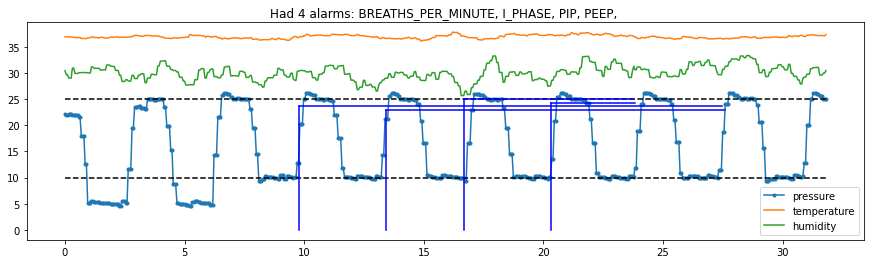

In [5]:
pl.rcParams['figure.figsize'] = [15, 4]

cc = Controller.get_control(control_setting_name = ControlSettingName.PEEP)
peep = cc.value

cc = Controller.get_control(control_setting_name = ControlSettingName.PIP)
pip = cc.value

pl.plot(tt, [s.pressure for s in ls], label = 'pressure', marker = '.')
pl.plot(tt, [s.temp for s in ls], label = "temperature")
pl.plot(tt, [s.humidity/3 for s in ls], label = "humidity")
pl.plot([np.min(tt), np.max(tt)], [pip, pip], 'k--')
pl.plot([np.min(tt), np.max(tt)], [peep, peep], 'k--')

active_alarms = Controller.get_active_alarms()
logged_alarms = Controller.get_logged_alarms()

pc = 0
for active_alarm_key in active_alarms.keys():
    alarm = active_alarms[active_alarm_key]
    pl.plot([alarm.alarm_start_time-t0+pc, alarm.alarm_start_time-t0+pc], [0,25], 'r-')
    pc += 0.1

pc=0
for alarm in logged_alarms:
    pl.plot([alarm.alarm_start_time-t0+pc, alarm.alarm_start_time-t0+pc], [0,25-7*pc], 'b-')
    pl.plot([alarm.alarm_start_time-t0+pc, alarm.alarm_end_time-t0+pc],  [25-7*pc,25-7*pc], 'b-')
    pc += 0.1

s = "Had " + str(len(Controller.get_alarms())) + " alarms: "
for alarm in Controller.get_alarms():
    s = s + alarm.alarm_name + ", "
    
pl.title(s)
pl.legend()

# Test 2

In [6]:
import sys
import time
import numpy as np
import pylab as pl
import random

sys.path.append('../') # get out of the sandbox

from vent.controller.control_module import get_control_module
from vent.common.message import SensorValues, ControlSetting, Alarm, AlarmSeverity, ControlSettingName

In [7]:
Controller = get_control_module(sim_mode=True)

Controller.do_state_control()

Already running State control.


In [8]:

Controller.start()
vals_start = Controller.get_sensors()

v_peep = 8 #random.randint(5, 10)
command = ControlSetting(name=ControlSettingName.PEEP, value=v_peep, min_value=v_peep-2, max_value=v_peep+2, timestamp=time.time())
Controller.set_control(command)

v_pip = 27 #random.randint(15, 30)
command = ControlSetting(name=ControlSettingName.PIP, value=v_pip, min_value=v_pip-2, max_value=v_pip+2, timestamp=time.time())
Controller.set_control(command)

v_bpm = 16 #random.randint(6, 20)
command = ControlSetting(name=ControlSettingName.BREATHS_PER_MINUTE, value=v_bpm, min_value=v_bpm-1, max_value=v_bpm+1, timestamp=time.time()) 
Controller.set_control(command)

v_iphase = 1.7918739225319527 #(0.3 + np.random.random()*0.5) * 60/v_bpm
command = ControlSetting(name=ControlSettingName.INSPIRATION_TIME_SEC, value=v_iphase, min_value=v_iphase-1, max_value=v_iphase+1, timestamp=time.time()) 
Controller.set_control(command)

ls = []
tt = []
t0 = time.time()
for t in np.arange(0, 30,0.05):
    
    if t%5==0:  # ask for a heartbeat from thread every 5 seconds
        print(Controller.heartbeat())
        print(t)    
    ## Do things
    
    vals = Controller.get_sensors()
    ls.append(vals)
    tt.append(time.time()  - t0)
    time.sleep(0.05)
    
    
    
Controller.stop() # consecutive stops should be ignored
Controller.stop() 
Controller.stop()

vals_stop = Controller.get_sensors()

assert (vals_stop.loop_counter - vals_start.loop_counter)  > 100 # In 20s, this program should go through a good couple of loops
assert np.abs(vals_stop.peep - v_peep)                     < 2    # PIP error correct within 2 cmH2O
assert np.abs(vals_stop.pip - v_pip)                       < 2    # PIP error correct within 2 cmH2O
assert np.abs(vals_stop.breaths_per_minute - v_bpm)        < 1    # Breaths per minute correct within 1 bpm
assert np.abs(vals_stop.inspiration_time_sec - v_iphase)   < 0.2  # Inspiration time   correct within 0.2 sec


0
0.0
451
5.0
897
10.0
1353
15.0
1798
20.0
2237
25.0


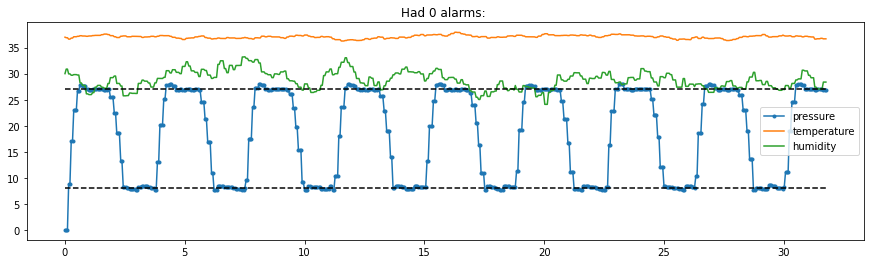

In [9]:
pl.rcParams['figure.figsize'] = [15, 4]

cc = Controller.get_control(control_setting_name = ControlSettingName.PEEP)
peep = cc.value

cc = Controller.get_control(control_setting_name = ControlSettingName.PIP)
pip = cc.value

pl.plot(tt, [s.pressure for s in ls], label = 'pressure', marker = '.')
pl.plot(tt, [s.temp for s in ls], label = "temperature")
pl.plot(tt, [s.humidity/3 for s in ls], label = "humidity")
pl.plot([np.min(tt), np.max(tt)], [pip, pip], 'k--')
pl.plot([np.min(tt), np.max(tt)], [peep, peep], 'k--')

active_alarms = Controller.get_active_alarms()
logged_alarms = Controller.get_logged_alarms()

pc = 0
for active_alarm_key in active_alarms.keys():
    alarm = active_alarms[active_alarm_key]
    pl.plot([alarm.alarm_start_time-t0+pc, alarm.alarm_start_time-t0+pc], [0,25], 'r-')
    pc += 0.1

pc=0
for alarm in logged_alarms:
    pl.plot([alarm.alarm_start_time-t0+pc, alarm.alarm_start_time-t0+pc], [0,25-7*pc], 'b-')
    pl.plot([alarm.alarm_start_time-t0+pc, alarm.alarm_end_time-t0+pc],  [25-7*pc,25-7*pc], 'b-')
    pc += 0.1

s = "Had " + str(len(Controller.get_alarms())) + " alarms: "
for alarm in Controller.get_alarms():
    s = s + alarm.alarm_name + ", "
    
pl.title(s)
pl.legend()